# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

# 2. ข้อมูล

ชุดข้อมูล MovieLens 100K Dataset

MovieLens คือ ชุดข้อมูลที่คัดมาแล้วอย่างดี มี 100,000 ratings จาก 1000 users ให้คะแนนหนัง 1700 เรื่อง เมื่อ 4/1998

ข้อมูลประกอบด้วย

* 100,000 ratings (คะแนน 1-5 ดาว) จาก 943 users ให้คะแนนหนัง 1682 เรื่อง
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)



รัน cell ด้านล่างเพื่อดาวน์โหลด [Movielen-100k](http://files.grouplens.org/datasets/movielens/ml-100k.zip) ไปใส่ไว้ที่ ~/.fastai/data/ml-100k แล้วแตกไฟล์

In [3]:
# ! wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
# ! mv ./ml-100k.zip ~/.fastai/data
# ! unzip ~/.fastai/data/ml-100k.zip -d ~/.fastai/data

In [4]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/home/jupyter/.fastai/data/ml-100k')

ls ดูว่ามีไฟล์อะไรบ้าง

In [5]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/ml-100k/ua.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.user'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.item'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ub.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.info'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/ua.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u2.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u5.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.occupation'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u4.base'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.genre'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u3.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u1.test'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/README'),
 PosixPath('/home/jupyter/.fastai/data/ml-100k/u.data'),
 PosixPath('/h

เนื่องจากข้อมูลไม่มี header เราต้องกำหนดชื่อ Column ให้เอง

In [6]:
user, item, title = 'userId', 'movieId', 'title'

โหลดไฟล์ u.data ขึ้นมาดู

In [7]:
dataframe_ratings = pd.read_csv(path/'u.data', 
                                delimiter='\t', header=None,
                                names=[user,item,'rating','timestamp'])

เปิดดู 5 แถวแรก

In [8]:
dataframe_ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


ดูสถิติของข้อมูล 

In [9]:
dataframe_ratings.userId = dataframe_ratings.userId.astype('category')
dataframe_ratings.movieId = dataframe_ratings.movieId.astype('category')

In [10]:
dataframe_ratings.describe(include='all')

,userId,movieId,rating,timestamp
count,100000.0,100000.0,100000.000000,1.000000e+05
unique,943.0,1682.0,NaN,NaN
top,405.0,50.0,NaN,NaN
freq,737.0,583.0,NaN,NaN
mean,NaN,NaN,3.529860,8.835289e+08
std,NaN,NaN,1.125674,5.343856e+06
min,NaN,NaN,1.000000,8.747247e+08
25%,NaN,NaN,3.000000,8.794487e+08
50%,NaN,NaN,4.000000,8.828269e+08
75%,NaN,NaN,4.000000,8.882600e+08


เคสนี้ทุก Column เป็นตัวเลขทั้งหมด สังเกต rating

1. count มีข้อมูล 100,000 Record แต่ละ Column เท่ากัน แสดงว่าข้อมูลครบสมบูรณ์
2. mean คะแนนเฉลี่ย คือ 3.53
3. std ค่าเบี่ยงเบนมาตรฐาน Standard Deviation คือ 1.12 แสดงว่าคะแนน 68% จะอยู่ระหว่าง 2.40 - 4.65
4. min คะแนนต่ำสุด คือ 1
5. max คะแนนสูงสุด คือ 5

# 3. เตรียมข้อมูล



## ข้อมูล Content

ถ้าเราดูแต่ movieId ก็จะไม่รู้ว่าเป็นหนังเรื่องไหน เราจะไปดึงข้อมูล Master ของ Movie มา merge 

โหลดข้อมูล Movies ขึ้นมา จะมีหลาย Column เช่น title, date, url, genre g0, g1, g2, ... etc. หมายถึง ประเภทของหนัง เช่น Action, Romantic หรือ Sci-fi 

*ซึ่งเราสามารถนำข้อมูลเหล่านี้ ประกอบกับข้อมูล ผู้กำกับ ดารานำ ค่ายหนัง และ ข้อมูลผู้ใช้ เช่น เพศ อายุ เชื้อชาติ ที่อยู่ etc. มาใช้ในการทำ Content-based recommendation ได้ต่อไป*

In [11]:
dataframe_movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
dataframe_movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Merge ข้อมูล โดยเอา item, title จาก Movies มาแปะ ดูตาม item ในที่นี้คือ movieId

In [12]:
dataframe_rating_movie = dataframe_ratings.merge(dataframe_movies[[item, title]])

เราลองมาดูคะแนนของ Toy Story (1995) ภาคแรก 5 คะแนนแรก

*การใช้ pandas dataframe filter เช่น df[df.id==1] จะอธิบายต่อไป*

In [13]:
dataframe_rating_movie[dataframe_rating_movie.movieId==1].head()

,userId,movieId,rating,timestamp,title
3397,308,1,4,887736532,Toy Story (1995)
3398,287,1,5,875334088,Toy Story (1995)
3399,148,1,4,877019411,Toy Story (1995)
3400,280,1,4,891700426,Toy Story (1995)
3401,66,1,3,883601324,Toy Story (1995)


สร้าง databunch แบ่งข้อมูลไว้เป็น Validation Set 10%

In [14]:
databunch = CollabDataBunch.from_df(dataframe_rating_movie, 
                                    seed=42, valid_pct=0.1,                                     
                                    item_name=title)

## สำรวจข้อมูล ##


*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [15]:
databunch.show_batch()

userId,title,target
30,Contact (1997),5.0
429,Sleepers (1996),3.0
641,Belle de jour (1967),4.0
861,Evita (1996),5.0
556,Rear Window (1954),5.0


# 4. สร้างโมเดล

จริง ๆ Rating ใน Dataset มีค่าตั้งแต่ 1-5 แต่เรากำหนดให้โมเดล มีช่วง Output y เป็น 0-5.5 กว้างกว่าความเป็นจริงนิดหน่อย จะทำให้โมเดลทำงานง่ายขึ้น

In [16]:
y_range = [0,5.5]

In [17]:
learner = collab_learner(databunch, n_factors=50, 
                         y_range=y_range, wd=1e-1, 
                         callback_fns=ShowGraph)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 5 Cycle สามารถใช้ Learning Rate สูง ๆ ได้เลย

epoch,train_loss,valid_loss,time
0,0.973297,0.933883,00:12
1,0.864168,0.889755,00:12
2,0.759486,0.836954,00:13
3,0.609546,0.818734,00:12
4,0.512218,0.819158,00:13


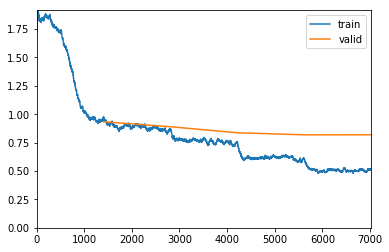

In [18]:
learner.fit_one_cycle(5, 5e-3)

## สำเร็จแล้ว ##

เพียงแค่เวลา 1 นาที เราเทรน Model เรียบร้อย เราจะมาดูผลลัพธ์กัน

*ในระบบจริงที่มี User และ Item จำนวนหลายล้าน เวลาที่ใช้ก็จะเพิ่มเป็นหลายชั่วโมง หรือหลายวัน ยังไม่รวมถึงเมื่อมี User และ Item ใหม่เข้ามาเพิ่มเรื่อย ๆ*

In [19]:
learner.save("06a-collab-filter")

In [20]:
learner.load("06a-collab-filter");

# 7. ดูผลลัพธ์

การวิเคราะห์ Embeding ที่มีหลายมิติ อย่างในเคสนี้เรานี้มี 50 มิติ ส่วนใหญ่เราจะใช้วิธีทางคณิตศาสตร์ เช่น t-SNE, pca, svd ลดมิติของข้อมูลลงให้เหลือ 3-4 มิติ เพื่อให้เรามาพล็อตกราฟแบบต่าง ๆ ตีความได้ 

## ดูโมเดล 

ดูภายในโมเดล หลังจากเทรนเรียบร้อยแล้ว เราจะได้ Embedding ดังนี้

1. Weight สำหรับ User และ Item (Movie) ขนาดเท่ากับ จำนวนข้อมูล x n_factors (50)
2. Bias สำหรับ User และ Item (Movie) ขนาดเท่ากับ จำนวนข้อมูล x 1

เนื่องจากเราไม่รู้ว่า User เป็นใครบ้าง แต่เราพอรู้จักหนัง Movie อยู่บ้าง เราจะเอา Weight, Bias ทั้ง 2 อย่าง ของเฉพาะ Movie มาตีความต่อไป

In [21]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1654, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

## ดูรีวิวหนัง 

เนื่องจากหนังใน Dataset มีถึง 1654 แต่หนังหลาย ๆ เรื่องมีคนรีวิวไม่กี่คน อาจจะทำให้คะแนนแกว่งได้ 

เรามาลองดูจำนวนรีวิวของหนังแต่ละเรื่อง สังเกตว่าหนังบางเรื่องที่ไม่ดัง มีคนรีวิวแค่ 4-5 คนเท่านั้น

In [22]:
movie_review_count = dataframe_rating_movie.groupby(title)['rating'].count()
movie_review_count[:20]

title
'Til There Was You (1997)                        9
1-900 (1994)                                     5
101 Dalmatians (1996)                          109
12 Angry Men (1957)                            125
187 (1997)                                      41
2 Days in the Valley (1996)                     93
20,000 Leagues Under the Sea (1954)             72
2001: A Space Odyssey (1968)                   259
3 Ninjas: High Noon At Mega Mountain (1998)      5
39 Steps, The (1935)                            59
8 1/2 (1963)                                    38
8 Heads in a Duffel Bag (1997)                   4
8 Seconds (1994)                                 4
A Chef in Love (1996)                            8
Above the Rim (1994)                             5
Absolute Power (1997)                          127
Abyss, The (1989)                              151
Ace Ventura: Pet Detective (1994)              103
Ace Ventura: When Nature Calls (1995)           37
Across the Sea of Time (1

เราจะมาคัดเฉพาะหนังน่าสนใจ ไม่ได้หมายถึงว่าหนังดี หรือหนังไม่ดี แต่หมายถึง หนังที่มีจำนวนคนเข้าไปรีวิวมากที่สุด 1000 อันดับแรก 

แสดงหัวท้าย ชื่อหนัง พร้อมจำนวนรีวิว 

In [23]:
top_movies = movie_review_count.sort_values(ascending=False)[:1000]
top_movies[:10], top_movies[-10:]

(title
 Star Wars (1977)                 583
 Contact (1997)                   509
 Fargo (1996)                     508
 Return of the Jedi (1983)        507
 Liar Liar (1997)                 485
 English Patient, The (1996)      481
 Scream (1996)                    478
 Toy Story (1995)                 452
 Air Force One (1997)             431
 Independence Day (ID4) (1996)    429
 Name: rating, dtype: int64, title
 Waiting to Exhale (1995)               16
 Ruling Class, The (1972)               16
 Gang Related (1997)                    16
 Exit to Eden (1994)                    16
 Bad Taste (1987)                       16
 Selena (1997)                          16
 In the Bleak Midwinter (1995)          16
 Party Girl (1995)                      16
 Highlander III: The Sorcerer (1994)    16
 Bastard Out of Carolina (1996)         16
 Name: rating, dtype: int64)

จะเห็นว่า หนังเรื่อง Star Wars (1977) จำนวนรีวิวมากสุด 583 น้อยสุดกลายเป็น 16 เพราะเราตัดที่ 1000

เราจะเอารายชื่อหนัง 1000 เรื่องนี้ดึง Embedding มาตีความดู ว่าจะตรงกับความเข้าใจของเราไหม

## ตีความจาก Bias ของ Movie Embeding 

Bias มีมิติเดียว และเรียกได้ว่าเป็นตัวบวก/ลบ มีผลกับ Rating ตรง ๆ เลย ทำให้เราตีความได้ว่า 

* Bias มาก = Rating สูง หนังดี
* Bias น้อย = Rating ต่ำ หนังไม่ดี

ดึง Bias ออกมาจากโมเดล

In [24]:
movie_bias = learner.bias(top_movies.index, is_item=True)
movie_bias.shape

torch.Size([1000])

ดึง Rating เฉลี่ยของหนังแต่ละเรื่อง จาก Dataset

เอามาใส่ใน Tuple ดังนี้ Bias, ชื่อหนัง, Rating เฉลี่ย

In [25]:
mean_ratings = dataframe_rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies.index,movie_bias)]

ประกาศฟังก์ชันที่ return Column แรก เอาไว้ใช้สำหรับ Sort เรียงตาม Column แรก

In [26]:
item0 = lambda o:o[0]

แสดงเรียงตาม Bias มากไปน้อย 15 อันดับแรก 

จะเห็นว่า หนังดี ได้รางวัลเกือบทั้งนั้น

In [27]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6035), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5865), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5560), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5475), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5424), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5370), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5295), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5106), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4925), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4803), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4765), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4548), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4502), 'Much Ado About Nothing (1993)', 4.0625),
 (tensor(0.4457), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4399), 'Fugitive, The (1993)', 4.044642857142857)]

แสดงเรียงตาม Bias น้อยไปมาก (ติดลบ) 15 อันดับแรก

จะเห็นว่า หนังไม่ค่อยดี ได้รับรางวัลมะเขือเน่าก็หลายเรื่อง

In [28]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3373),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3019),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2868), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2827), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2628), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2536), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2473), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2436), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2347), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2295), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2218), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2179), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2143), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2104), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2043), 'G

สรุป Bias ค่อนข้างไปในทางเดียวกับ Rating เฉลี่ย

## ตีความจาก Weight ของ Movie Embeding 

Weight มีหลายมิติให้เราตีความได้หลากหลายมากขึ้น หนึ่งในการตีความคือ เราสามารถเปรียบเทียบได้ว่า ถ้าหนังเรื่อง 2 เรื่อง Weight ใกล้เคียงกัน กว่าหนังเรื่องอื่น ก็จะมีอะไรที่ใกล้เคียงกัน เช่น เนื้อเรื่องใกล้เคียงกัน นักแสดงชุดเดียวกัน หรืออาจจะเป็นภาคต่อ โดยที่เราไม่ได้ใช้ข้อมูล Genre จากใน Master เลย ใช้แต่ Rating จาก User เท่านั้น

ดึง Weight ออกมาจากโมเดล

In [29]:
movie_weight = learner.weight(top_movies.index, is_item=True)
movie_weight.shape

torch.Size([1000, 50])

ใช้ PCA เพื่อลดมิติข้อมูล จาก 1000 มิติ ให้เหลือแค่ 3 มิติ แต่ยังคงข้อมูลส่วนใหญ่อยู่

*เรื่อง Dimensionality reduction, PCA, SVD, MDS, ICA จะอธิบายต่อไป* 

In [30]:
movie_pca = movie_weight.pca(3)
movie_pca.shape

torch.Size([1000, 3])

ดึงค่าทั้ง 3 มิติออกมา 

เอามิติแรก เตรียมนำมาแสดงผล

In [31]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies.index)]

แสดงรายการหนัง เรียงตามมิติแรก มากไปน้อย

ตีความว่า อาจจะเป็น มิติความสดใส หนังเด็ก

In [32]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2550), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.2316), 'Home Alone 3 (1997)'),
 (tensor(1.2088), 'Jungle2Jungle (1997)'),
 (tensor(1.2040), "McHale's Navy (1997)"),
 (tensor(1.1360), 'Leave It to Beaver (1997)'),
 (tensor(1.1057), 'Bio-Dome (1996)'),
 (tensor(1.1021), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0952), 'Flipper (1996)'),
 (tensor(1.0736), 'Congo (1995)'),
 (tensor(1.0473), 'Richie Rich (1994)')]

แสดงรายการหนัง เรียงตามมิติแรก น้อยไปมาก 

ตีความว่า อาจจะเป็น มิติความคลาสสิค หนังผู้ใหญ่

In [33]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0398), 'Close Shave, A (1995)'),
 (tensor(-1.0269), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0215), 'Godfather, The (1972)'),
 (tensor(-1.0127), 'Secrets & Lies (1996)'),
 (tensor(-1.0050), 'When We Were Kings (1996)'),
 (tensor(-0.9898), 'Casablanca (1942)'),
 (tensor(-0.9876), 'Chinatown (1974)'),
 (tensor(-0.9854), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9829),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9677), 'Ran (1985)')]

มิติที่ 2 

In [34]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies.index)]

แสดงรายการหนัง เรียงตามมิติที่สอง มากไปน้อย

ตีความว่า อาจจะเป็น มิติความสัมพันธ์ เรื่องไม่ซีเรียส

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0168), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7771), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7664), 'Trainspotting (1996)'),
 (tensor(0.7549), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7544), 'Heavenly Creatures (1994)'),
 (tensor(0.7479), 'Keys to Tulsa (1997)'),
 (tensor(0.7445), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7440), 'Jude (1996)'),
 (tensor(0.7425), 'Sweet Hereafter, The (1997)'),
 (tensor(0.7258), 'Cable Guy, The (1996)')]

แสดงรายการหนัง เรียงตามมิติที่สอง น้อยไปมาก 

ตีความว่า อาจจะเป็น มิติความแอคชั่น Epic

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2185), 'Braveheart (1995)'),
 (tensor(-1.1252), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0450), 'Titanic (1997)'),
 (tensor(-0.9029), 'Forrest Gump (1994)'),
 (tensor(-0.8926), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8856), "It's a Wonderful Life (1946)"),
 (tensor(-0.8479), 'American President, The (1995)'),
 (tensor(-0.8439), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8353), 'Air Force One (1997)'),
 (tensor(-0.8311), 'Star Wars (1977)')]

เราลองเอา มาพล็อตกราฟดู

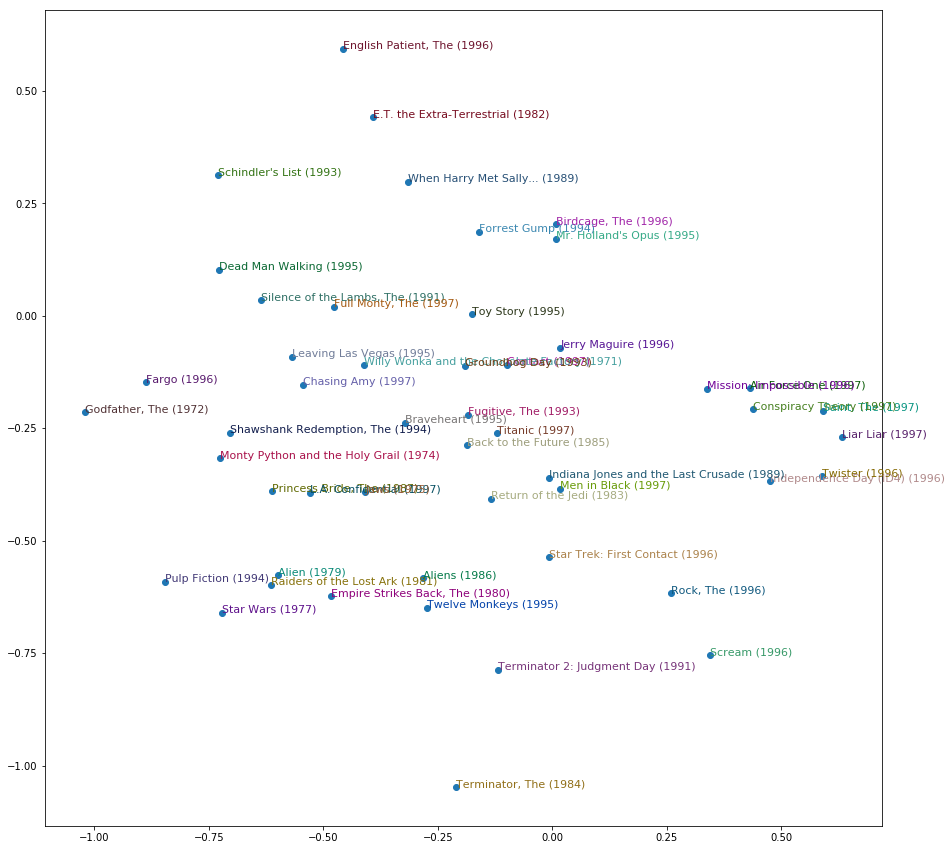

In [40]:
idxs = np.random.choice(len(top_movies.index), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies.index[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

จะเห็นว่าหนังเนื้อหาใกล้เคียงกัน จะอยู่ตำแหน่งใกล้เคียงกัน

# 9. สรุป

1. การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน Collaborative Filtering แบบนี้ ถ้าข้อมูลไม่มากใช้เวลาไม่ถึง 1 นาที และไม่จำเป็นต้องใช้ GPU
2. เราสามารถสร้าง โมเดล Collaborative Filtering จากข้อมูล User Rating ได้ไม่ยาก แต่จะมีประเด็นเรื่อง Cold Start ในกรณี User, Item มาเพิ่มใหม่จะทำอย่างไร ส่วนใหญ่เราจะใช้วิธี Hybrid คือ ผสมกับ Content based และ Knowledge based Recommendation System จะอธิบายต่อไป
3. โมเดลแบบนี้ สามารถนำไปประยุกต์ใช้ใน App ที่มีอยู่แล้ว เพื่อเพิ่มมูลค่า แนะนำสินค้าใหม่ ๆ ให้ลูกค้าเดิม เพิ่มยอดขายได้ โดยลูกค้าได้รับความพึงพอใจมากขึ้นด้วย

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 4](https://course.fast.ai/videos/?lesson=4)
* [Movielens-100k](https://grouplens.org/datasets/movielens/100k/)
* F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872
* https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a
* https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb